# DA5401 A6: Imputation via Regression for Missing Data 

### Objective: This assignment challenges you to apply linear and non-linear regression to impute missing values in a dataset. The effectiveness of your imputation methods will be measured indirectly by assessing the performance of a subsequent classification task, comparing the regression-based approach against simpler imputation strategies.

# Part A: Data Preprocessing and Imputation

## Load and Prepare Data

In [3]:
# --- Core Libraries for Data Handling and Numerical Operations ---
import pandas as pd
import numpy as np

# --- Libraries for Data Visualization ---
import matplotlib.pyplot as plt
import seaborn as sns

# --- Scikit-Learn for Preprocessing ---
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# --- Scikit-Learn for Imputation Models (Regression) ---
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor

# --- Scikit-Learn for the Final Classification Model ---
from sklearn.linear_model import LogisticRegression

# --- Scikit-Learn for Model Evaluation ---
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score

# --- To disable warnings for a cleaner notebook ---
import warnings
warnings.filterwarnings('ignore')

In [4]:
df = pd.read_csv('UCI_Credit_Card.csv')

# --- 1. Initial Data Inspection ---
print(f"\nOriginal dataset shape: {df.shape}")
print("\n--- First 5 Rows of the Dataset ---")
print(df.head())
print("--- Original Data Info ---")
print(df.info())



# The target variable is 'default.payment.next.month'
# Let's rename it for easier access
df.rename(columns={'default.payment.next.month': 'DEFAULT'}, inplace=True)


Original dataset shape: (30000, 25)

--- First 5 Rows of the Dataset ---
   ID  LIMIT_BAL  SEX  EDUCATION  MARRIAGE  AGE  PAY_0  PAY_2  PAY_3  PAY_4  \
0   1    20000.0    2          2         1   24      2      2     -1     -1   
1   2   120000.0    2          2         2   26     -1      2      0      0   
2   3    90000.0    2          2         2   34      0      0      0      0   
3   4    50000.0    2          2         1   37      0      0      0      0   
4   5    50000.0    1          2         1   57     -1      0     -1      0   

   ...  BILL_AMT4  BILL_AMT5  BILL_AMT6  PAY_AMT1  PAY_AMT2  PAY_AMT3  \
0  ...        0.0        0.0        0.0       0.0     689.0       0.0   
1  ...     3272.0     3455.0     3261.0       0.0    1000.0    1000.0   
2  ...    14331.0    14948.0    15549.0    1518.0    1500.0    1000.0   
3  ...    28314.0    28959.0    29547.0    2000.0    2019.0    1200.0   
4  ...    20940.0    19146.0    19131.0    2000.0   36681.0   10000.0   

   PAY_AMT4 

--- Plotting Original Distributions of 'AGE' and 'BILL_AMT1' ---


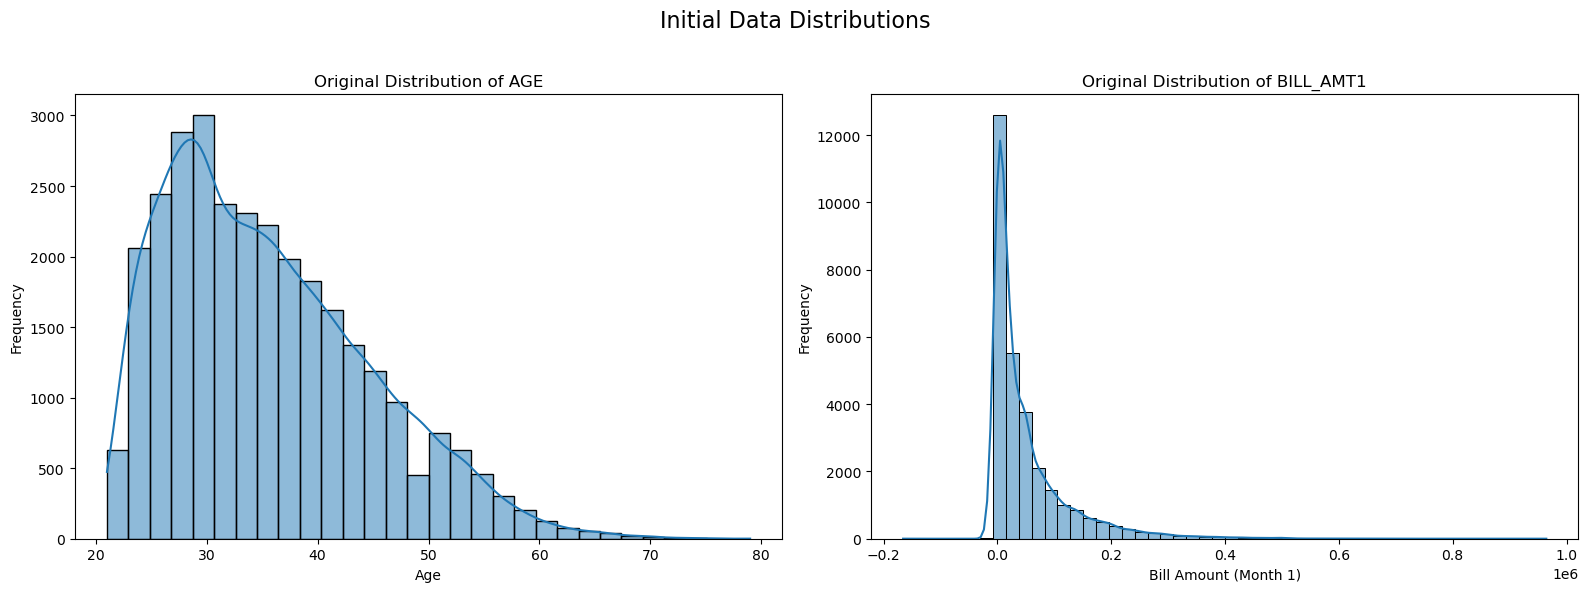

In [5]:
# --- Visualize Original Distributions ---
print("--- Plotting Original Distributions of 'AGE' and 'BILL_AMT1' ---")

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot for AGE
sns.histplot(df['AGE'], bins=30, kde=True, ax=axes[0])
axes[0].set_title("Original Distribution of AGE")
axes[0].set_xlabel("Age")
axes[0].set_ylabel("Frequency")

# Plot for BILL_AMT1
sns.histplot(df['BILL_AMT1'], bins=50, kde=True, ax=axes[1])
axes[1].set_title("Original Distribution of BILL_AMT1")
axes[1].set_xlabel("Bill Amount (Month 1)")
axes[1].set_ylabel("Frequency")

plt.suptitle("Initial Data Distributions", fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig("initial_distributions.png")
plt.show()

## Artificially introduce Missing At Random (MAR) values

In [6]:
# --- 2. Artificially Introduce Missing Values ---
# Create a copy to work with, preserving the original dataframe
df_missing = df.copy()
# Specify columns to introduce missing values and the percentage of missingness
cols_to_null = ['AGE', 'BILL_AMT1', 'PAY_AMT1']
percent_missing = 0.10 

print(f"\n--- Introducing {percent_missing:.0%} Missing Values ---")
for col in cols_to_null:
    # Calculate the number of values to replace with NaN
    n_missing = int(len(df_missing) * percent_missing)

    # Randomly select indices to set to NaN
    # We use 'replace=False' to ensure we don't pick the same index twice
    missing_indices = np.random.choice(df_missing.index, n_missing, replace=False)

    # Set the selected indices in the column to NaN
    df_missing.loc[missing_indices, col] = np.nan
    print(f"Introduced {n_missing} missing values into the '{col}' column.")

# --- Verify the Missing Values ---
print("\n--- Verification of Missing Values ---")
print("Number of missing values per column:")
print(df_missing.isnull().sum())


--- Introducing 10% Missing Values ---
Introduced 3000 missing values into the 'AGE' column.
Introduced 3000 missing values into the 'BILL_AMT1' column.
Introduced 3000 missing values into the 'PAY_AMT1' column.

--- Verification of Missing Values ---
Number of missing values per column:
ID              0
LIMIT_BAL       0
SEX             0
EDUCATION       0
MARRIAGE        0
AGE          3000
PAY_0           0
PAY_2           0
PAY_3           0
PAY_4           0
PAY_5           0
PAY_6           0
BILL_AMT1    3000
BILL_AMT2       0
BILL_AMT3       0
BILL_AMT4       0
BILL_AMT5       0
BILL_AMT6       0
PAY_AMT1     3000
PAY_AMT2        0
PAY_AMT3        0
PAY_AMT4        0
PAY_AMT5        0
PAY_AMT6        0
DEFAULT         0
dtype: int64


## Imputation Strategy 1: Simple Imputation (Baseline)

In [7]:
# Create a copy of the dataframe with missing values for this strategy
dataset_A = df_missing.copy()

# Identify columns with missing values
cols_with_missing = ['AGE', 'BILL_AMT1', 'PAY_AMT1']

print("--- Applying Median Imputation to Dataset A ---")
for col in cols_with_missing:
    # Calculate the median of the column (it automatically ignores NaN values)
    median_value = dataset_A[col].median()
    
    # Fill missing values with the calculated median
    dataset_A[col].fillna(median_value, inplace=True)
    
    print(f"Missing values in '{col}' filled with median value: {median_value}")

# --- Verification ---
print("\n--- Verifying Missing Values in Dataset A ---")
print("Number of missing values per column after imputation:")
# We only expect the two columns we targeted to be 0
print(dataset_A[cols_with_missing].isnull().sum())

--- Applying Median Imputation to Dataset A ---
Missing values in 'AGE' filled with median value: 34.0
Missing values in 'BILL_AMT1' filled with median value: 22288.0
Missing values in 'PAY_AMT1' filled with median value: 2100.0

--- Verifying Missing Values in Dataset A ---
Number of missing values per column after imputation:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


## Why is the median often preferred over the mean for imputation?
The median is often preferred over the mean for imputation primarily because it is more robust to outliers.

Impact of Outliers: The mean is calculated by summing all values and dividing by the count. A few extremely high or low values (outliers) can significantly skew the mean, making it a poor representation of the "typical" value in the dataset. The median, on the other hand, is simply the middle value of a sorted dataset. It is not affected by the magnitude of extreme values, only by their position.

Data Distribution: In datasets with a skewed distribution, such as financial data (e.g., 'BILL_AMT1'), the mean is pulled towards the long tail. The median, however, remains a better indicator of the central tendency.

By using the median, we ensure that the values we impute are representative of the majority of the data points and are not distorted by anomalies.

## Imputation Strategy 2: Regression Imputation (Linear)

In [8]:
# Create a second copy of the dataframe with missing values
dataset_B = df_missing.copy()

print("--- Applying Linear Regression Imputation to 'AGE' in Dataset B ---")
print(f"Missing values in 'AGE' before imputation: {dataset_B['AGE'].isnull().sum()}")
print(f"Missing values in 'BILL_AMT1' before imputation: {dataset_B['BILL_AMT1'].isnull().sum()}")

# 1. Prepare the data for the regression model
# The features (X) will be all columns except the one we're predicting ('AGE'),
# the other column with NaNs ('BILL_AMT1'), the target ('DEFAULT'), and the ID.
# The target for this small model (y) is the 'AGE' column.
imputation_model_features = dataset_B.drop(columns=['AGE', 'BILL_AMT1', 'PAY_AMT1', 'DEFAULT', 'ID'])
imputation_model_target = dataset_B['AGE']

# 2. Split the dataset into two parts:
# - A training set where 'AGE' is not missing.
# - A prediction set where 'AGE' is missing.
X_train = imputation_model_features[imputation_model_target.notna()]
y_train = imputation_model_target[imputation_model_target.notna()]
X_predict = imputation_model_features[imputation_model_target.isna()]

# 3. Train the Linear Regression model
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# 4. Predict the missing 'AGE' values
predicted_age = lin_reg.predict(X_predict)

# The model might predict negative or fractional ages, so we'll round and ensure age is positive.
predicted_age = np.round(predicted_age)
predicted_age[predicted_age < 0] = 0 # Set any negative predictions to 0

# 5. Fill the missing values in Dataset B with the predictions
dataset_B.loc[imputation_model_target.isna(), 'AGE'] = predicted_age
print(f"\nSuccessfully imputed missing values in 'AGE'.")

# 6. Handle the other column ('BILL_AMT1')
# The instructions are to use regression for a single column.
# We'll fill the remaining column with the median to make the dataset complete.
bill_amt_median = dataset_B['BILL_AMT1'].median()
dataset_B['BILL_AMT1'].fillna(bill_amt_median, inplace=True)
print(f"Filled remaining missing values in 'BILL_AMT1' with median: {bill_amt_median}")

pay_amt1_median = dataset_B['PAY_AMT1'].median()
dataset_B['PAY_AMT1'].fillna(pay_amt1_median, inplace=True)
print(f"Filled remaining missing values in 'PAY_AMT1' with median: {pay_amt1_median}")


# --- Verification ---
print("\n--- Verifying Missing Values in Dataset B ---")
print("Number of missing values per column after all imputations:")
print(dataset_B[['AGE', 'BILL_AMT1', 'PAY_AMT1']].isnull().sum())

--- Applying Linear Regression Imputation to 'AGE' in Dataset B ---
Missing values in 'AGE' before imputation: 3000
Missing values in 'BILL_AMT1' before imputation: 3000

Successfully imputed missing values in 'AGE'.
Filled remaining missing values in 'BILL_AMT1' with median: 22288.0
Filled remaining missing values in 'PAY_AMT1' with median: 2100.0

--- Verifying Missing Values in Dataset B ---
Number of missing values per column after all imputations:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


## The "Missing At Random" (MAR) Assumption

Missing At Random (MAR) is a key assumption that underlies many sophisticated imputation methods, including regression imputation. It does not mean that the data is missing haphazardly.

Instead, MAR means that the probability of a value being missing is related to other observed information in the dataset, but not to the missing value itself.

Analogy: Consider a health survey.

MAR Scenario: Suppose men are less likely than women to answer a question about their diet. The "missingness" of the diet information depends on the 'gender' column, which we have observed. We can use gender (and other observed data like age or location) to build a model and make an educated guess about the missing diet information. This is the core idea of regression imputation.

This is different from two other cases:

Missing Completely At Random (MCAR): The missingness is totally random, like a data entry clerk accidentally skipping a few cells. It has no connection to any other variable. Simple median/mean imputation works reasonably well here.

Missing Not At Random (MNAR): The missingness is related to the value that is missing. For example, people with very high salaries might intentionally skip the "income" question. We can't use other variables to fix this because the reason it's missing is the very value we don't have. This is the most difficult type of missing data to handle.

Regression imputation is effective because it leverages the MAR assumption, using the relationships present in the data to make intelligent predictions for the missing values

## Imputation Strategy 3: Regression Imputation (Non-Linear)

In [9]:
# Create a third copy of the dataframe with missing values
dataset_C = df_missing.copy()

print("--- Applying KNN Regression Imputation to 'AGE' in Dataset C ---")
print(f"Missing values in 'AGE' before imputation: {dataset_C['AGE'].isnull().sum()}")

# 1. Prepare the data for the regression model (same setup as before)
imputation_model_features_nl = dataset_C.drop(columns=['AGE', 'BILL_AMT1', 'PAY_AMT1', 'DEFAULT', 'ID'])
imputation_model_target_nl = dataset_C['AGE']

# 2. Split the dataset into training and prediction sets
X_train_nl = imputation_model_features_nl[imputation_model_target_nl.notna()]
y_train_nl = imputation_model_target_nl[imputation_model_target_nl.notna()]
X_predict_nl = imputation_model_features_nl[imputation_model_target_nl.isna()]

# 3. Train the K-Nearest Neighbors Regressor model
# We'll use k=5, a common choice for the number of neighbors.
knn_reg = KNeighborsRegressor(n_neighbors=5)
knn_reg.fit(X_train_nl, y_train_nl)

# 4. Predict the missing 'AGE' values
predicted_age_knn = knn_reg.predict(X_predict_nl)

# KNN averages the ages of neighbors, so we should round the result to get an integer age.
predicted_age_knn = np.round(predicted_age_knn)

# 5. Fill the missing values in Dataset C with the predictions
dataset_C.loc[imputation_model_target_nl.isna(), 'AGE'] = predicted_age_knn
print(f"\nSuccessfully imputed missing values in 'AGE' using KNN.")

# 6. Handle the other column ('BILL_AMT1') with the median
bill_amt_median_c = dataset_C['BILL_AMT1'].median()
dataset_C['BILL_AMT1'].fillna(bill_amt_median_c, inplace=True)
print(f"Filled remaining missing values in 'BILL_AMT1' with median: {bill_amt_median_c}")

pay_amt1_median_c = dataset_B['PAY_AMT1'].median()
dataset_C['PAY_AMT1'].fillna(pay_amt1_median_c, inplace=True)
print(f"Filled remaining missing values in 'PAY_AMT1' with median: {pay_amt1_median_c}")

# --- Verification ---
print("\n--- Verifying Missing Values in Dataset C ---")
print("Number of missing values per column after all imputations:")
print(dataset_C[['AGE', 'BILL_AMT1', 'PAY_AMT1']].isnull().sum())

--- Applying KNN Regression Imputation to 'AGE' in Dataset C ---
Missing values in 'AGE' before imputation: 3000

Successfully imputed missing values in 'AGE' using KNN.
Filled remaining missing values in 'BILL_AMT1' with median: 22288.0
Filled remaining missing values in 'PAY_AMT1' with median: 2100.0

--- Verifying Missing Values in Dataset C ---
Number of missing values per column after all imputations:
AGE          0
BILL_AMT1    0
PAY_AMT1     0
dtype: int64


--- Comparing 'AGE' Distributions After Imputation ---


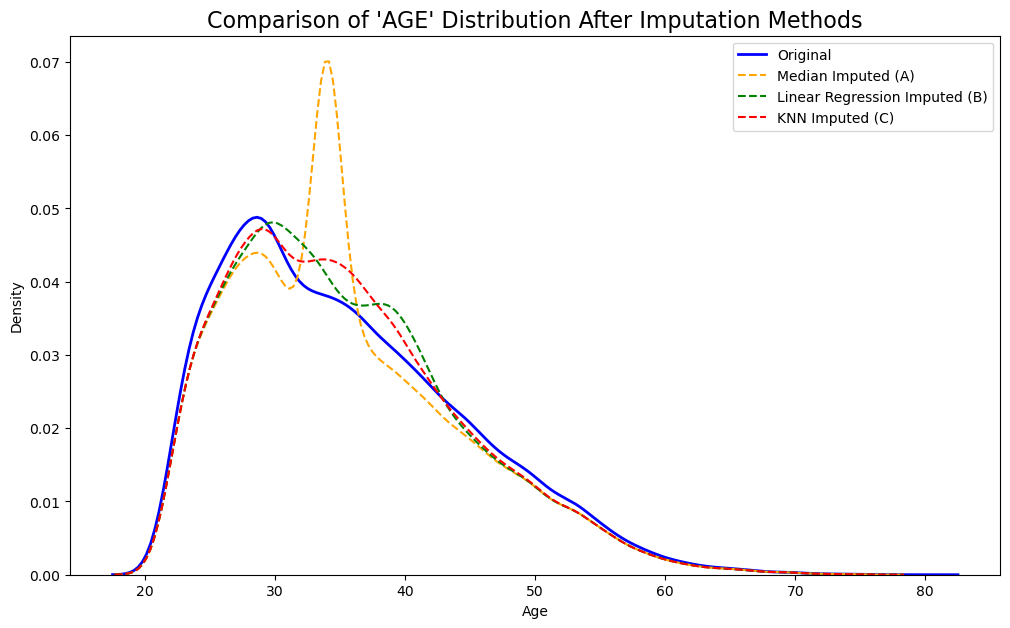

In [10]:
# --- Visualize and Compare Imputed Distributions for 'AGE'---
print("--- Comparing 'AGE' Distributions After Imputation ---")

plt.figure(figsize=(12, 7))

# Plotting the density of the 'AGE' column from each dataset
sns.kdeplot(df['AGE'].dropna(), label='Original', color='blue', linewidth=2)
sns.kdeplot(dataset_A['AGE'], label='Median Imputed (A)', color='orange', linestyle='--')
sns.kdeplot(dataset_B['AGE'], label='Linear Regression Imputed (B)', color='green', linestyle='--')
sns.kdeplot(dataset_C['AGE'], label='KNN Imputed (C)', color='red', linestyle='--')

plt.title("Comparison of 'AGE' Distribution After Imputation Methods", fontsize=16)
plt.xlabel("Age")
plt.ylabel("Density")
plt.legend()
plt.savefig("imputation_comparison.png")
plt.show()

--- Comparing 'BILL_AMT1' Distributions After Imputation ---


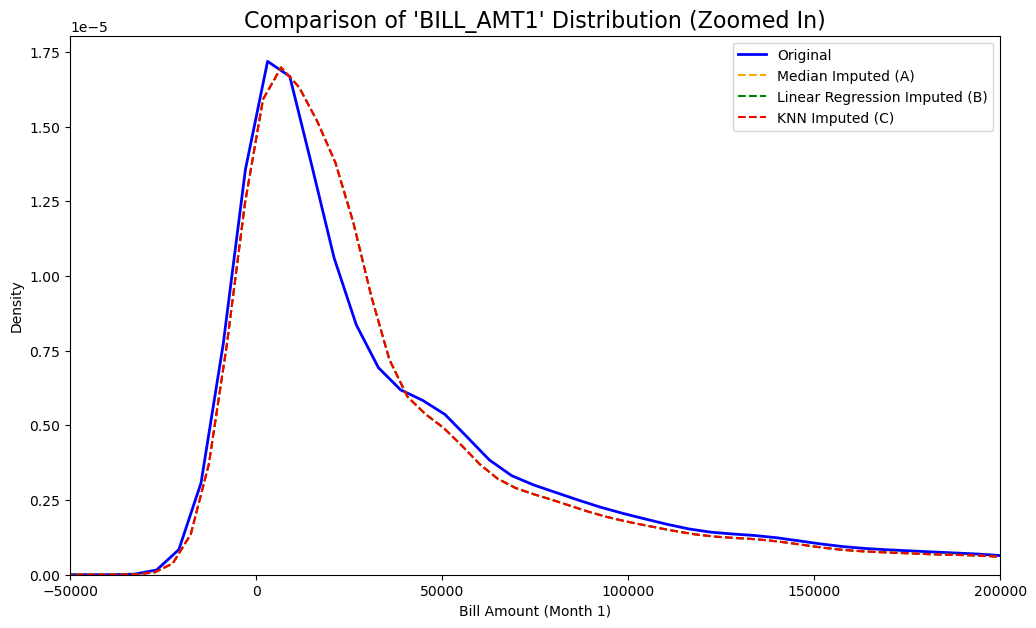

In [11]:
# --- Visualize and Compare Imputed Distributions for 'BILL_AMT1'---
print("--- Comparing 'BILL_AMT1' Distributions After Imputation ---")

plt.figure(figsize=(12, 7))

# Plotting the density of the 'BILL_AMT1' column from each dataset
sns.kdeplot(df['BILL_AMT1'].dropna(), label='Original', color='blue', linewidth=2)
sns.kdeplot(dataset_A['BILL_AMT1'], label='Median Imputed (A)', color='orange', linestyle='--')
sns.kdeplot(dataset_B['BILL_AMT1'], label='Linear Regression Imputed (B)', color='green', linestyle='--')
sns.kdeplot(dataset_C['BILL_AMT1'], label='KNN Imputed (C)', color='red', linestyle='--')

plt.title("Comparison of 'BILL_AMT1' Distribution (Zoomed In)", fontsize=16)
plt.xlabel("Bill Amount (Month 1)")
plt.ylabel("Density")


plt.xlim(-50000, 200000)

plt.legend()
plt.savefig("imputation_comparison_bill_amt_zoomed.png")
plt.show()


# Part B: Model Training and Performance Assessment

## Data Split 

In [12]:
# --- Create Dataset D (Listwise Deletion) ---
print("--- Creating Dataset D by Listwise Deletion ---")

# .dropna() removes any row containing at least one NaN value.
dataset_D = df_missing.dropna().copy()

print(f"Shape of the dataset before deletion (df_missing): {df_missing.shape}")
print(f"Shape of the dataset after deletion (Dataset D):   {dataset_D.shape}")
print(f"Number of rows dropped: {len(df_missing) - len(dataset_D)}")

# --- Prepare for Splitting All Datasets ---
# Let's put all our datasets into a dictionary for easy processing
datasets = {
    'A': dataset_A,
    'B': dataset_B,
    'C': dataset_C,
    'D': dataset_D
}

# We will store the split data in these dictionaries
X_train_sets, X_test_sets, y_train_sets, y_test_sets = {}, {}, {}, {}

print("\n--- Splitting All Datasets into Training and Testing Sets ---")

for key, df in datasets.items():
    # Define features (X) and target (y)
    # We drop the ID column as it's not a predictive feature
    X = df.drop(columns=['DEFAULT', 'ID'])
    y = df['DEFAULT']
    
    # Split the data with a 20% test size and a random_state for reproducibility
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
    
    # Store the results
    X_train_sets[key] = X_train
    X_test_sets[key] = X_test
    y_train_sets[key] = y_train
    y_test_sets[key] = y_test
    
    print(f"Dataset {key}:")
    print(f"  X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
    print(f"  X_test shape:  {X_test.shape},  y_test shape:  {y_test.shape}")

--- Creating Dataset D by Listwise Deletion ---
Shape of the dataset before deletion (df_missing): (30000, 25)
Shape of the dataset after deletion (Dataset D):   (21869, 25)
Number of rows dropped: 8131

--- Splitting All Datasets into Training and Testing Sets ---
Dataset A:
  X_train shape: (24000, 23), y_train shape: (24000,)
  X_test shape:  (6000, 23),  y_test shape:  (6000,)
Dataset B:
  X_train shape: (24000, 23), y_train shape: (24000,)
  X_test shape:  (6000, 23),  y_test shape:  (6000,)
Dataset C:
  X_train shape: (24000, 23), y_train shape: (24000,)
  X_test shape:  (6000, 23),  y_test shape:  (6000,)
Dataset D:
  X_train shape: (17495, 23), y_train shape: (17495,)
  X_test shape:  (4374, 23),  y_test shape:  (4374,)


## Classifier Setup

In [13]:
# Initialize the StandardScaler
scaler = StandardScaler()

# Dictionaries to store the scaled data
X_train_scaled_sets = {}
X_test_scaled_sets = {}

print("--- Standardizing Features for All Datasets ---")

for key in datasets.keys():
    # Retrieve the train and test sets for the current dataset
    X_train = X_train_sets[key]
    X_test = X_test_sets[key]
    
    # Fit the scaler on the training data and transform it
    X_train_scaled = scaler.fit_transform(X_train)
    
    # Use the SAME fitted scaler to transform the test data
    X_test_scaled = scaler.transform(X_test)
    
    # For convenience, convert the scaled arrays back to DataFrames
    # This preserves the column names and indices
    X_train_scaled_sets[key] = pd.DataFrame(X_train_scaled, index=X_train.index, columns=X_train.columns)
    X_test_scaled_sets[key] = pd.DataFrame(X_test_scaled, index=X_test.index, columns=X_test.columns)
    
    print(f"Dataset {key} features have been successfully scaled.")

# --- Verification ---
# Let's check the description of one of the scaled training sets to confirm.
# The mean of each column should be close to 0 and the standard deviation close to 1.
print("\n--- Verification of Scaling on Dataset A's Training Data ---")
print(X_train_scaled_sets['A'].describe())

--- Standardizing Features for All Datasets ---
Dataset A features have been successfully scaled.
Dataset B features have been successfully scaled.
Dataset C features have been successfully scaled.
Dataset D features have been successfully scaled.

--- Verification of Scaling on Dataset A's Training Data ---
          LIMIT_BAL           SEX     EDUCATION      MARRIAGE           AGE  \
count  2.400000e+04  2.400000e+04  2.400000e+04  2.400000e+04  2.400000e+04   
mean   8.437695e-17  2.507624e-16 -4.115227e-17  8.881784e-19 -3.034610e-16   
std    1.000021e+00  1.000021e+00  1.000021e+00  1.000021e+00  1.000021e+00   
min   -1.215090e+00 -1.236950e+00 -2.339588e+00 -2.975474e+00 -1.638108e+00   
25%   -9.062306e-01 -1.236950e+00 -1.077532e+00 -1.059367e+00 -7.220923e-01   
50%   -2.112961e-01  8.084404e-01  1.845230e-01  8.567391e-01 -1.495825e-01   
75%    5.608533e-01  8.084404e-01  1.845230e-01  8.567391e-01  5.374292e-01   
max    6.429189e+00  8.084404e-01  5.232745e+00  2.772846e

## Model Evaluation

In [14]:
# Dictionaries to store the trained models and their reports
models = {}
reports = {}

print("--- Training and Evaluating Logistic Regression Classifiers ---")

for key in datasets.keys():
    print(key)
    # Retrieve the scaled train and test sets for the current dataset
    X_train = X_train_scaled_sets[key]
    y_train = y_train_sets[key]
    X_test = X_test_scaled_sets[key]
    y_test = y_test_sets[key]
    
    # Initialize the Logistic Regression model
    # Using random_state for reproducibility of results
    log_reg = LogisticRegression(random_state=42)
    
    # Train the model on the training data
    log_reg.fit(X_train, y_train)
    
    # Make predictions on the test data
    y_pred = log_reg.predict(X_test)
    
    # Generate the classification report
    report = classification_report(y_test, y_pred)
    
    # Store the trained model and the report
    models[key] = log_reg
    reports[key] = report
    
    # Print the results for each model
    print(f"\n--- Classification Report for Model {key} ---")
    if key == 'A':
        print("(Imputation: Median)")
    elif key == 'B':
        print("(Imputation: Linear Regression)")
    elif key == 'C':
        print("(Imputation: Non-Linear KNN Regression)")
    else: # key == 'D'
        print("(Method: Listwise Deletion)")
        
    print(report)

--- Training and Evaluating Logistic Regression Classifiers ---
A

--- Classification Report for Model A ---
(Imputation: Median)
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.35      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

B

--- Classification Report for Model B ---
(Imputation: Linear Regression)
              precision    recall  f1-score   support

           0       0.82      0.97      0.89      4673
           1       0.69      0.24      0.36      1327

    accuracy                           0.81      6000
   macro avg       0.75      0.60      0.62      6000
weighted avg       0.79      0.81      0.77      6000

C

--- Classification Report for Model C ---
(Imputation: Non-Linear KNN Regression)
              precision    recall  f1-score   support


# Part C: Comparative Analysis

## Results Comparison

In [15]:
summary_data = []

# A dictionary to map model keys to their method names for clarity in the table
model_methods = {
    'A': 'Median Imputation',
    'B': 'Linear Regression Imputation',
    'C': 'Non-Linear (KNN) Imputation',
    'D': 'Listwise Deletion'
}

for key, report_str in reports.items():
    # Split the report string into lines
    lines = report_str.strip().split('\n')
    
    # --- Extract metrics for class '1' (default) ---
    # Find the line corresponding to class '1'
    class_1_line = [line for line in lines if line.strip().startswith('1')][0]
    class_1_metrics = class_1_line.split()
    
    precision_1 = float(class_1_metrics[1])
    recall_1 = float(class_1_metrics[2])
    f1_score_1 = float(class_1_metrics[3])
    
    # --- Extract overall accuracy ---
    accuracy_line = [line for line in lines if 'accuracy' in line][0]
    accuracy = float(accuracy_line.split()[1])
    
    # Store the extracted metrics in a dictionary
    model_performance = {
        'Model': f"Model {key}",
        'Imputation Method': model_methods[key],
        'Accuracy': f"{accuracy:.2%}",
        'Precision (Default)': precision_1,
        'Recall (Default)': recall_1,
        'F1-score (Default)': f1_score_1
    }
    summary_data.append(model_performance)

# Create a pandas DataFrame from the collected data
summary_df = pd.DataFrame(summary_data)
summary_df.set_index('Model', inplace=True)

print("--- Summary of Model Performance ---")
display(summary_df)

# For a more focused comparison, let's highlight the F1-score
print("\n--- F1-Score Comparison ---")
summary_df_sorted = summary_df.sort_values(by='F1-score (Default)', ascending=False)
display(summary_df_sorted[['Imputation Method', 'F1-score (Default)']])

--- Summary of Model Performance ---


,Imputation Method,Accuracy,Precision (Default),Recall (Default),F1-score (Default)
Model,,,,,
Model A,Median Imputation,81.00%,0.69,0.24,0.35
Model B,Linear Regression Imputation,81.00%,0.69,0.24,0.36
Model C,Non-Linear (KNN) Imputation,81.00%,0.69,0.24,0.35
Model D,Listwise Deletion,81.00%,0.73,0.23,0.35



--- F1-Score Comparison ---


,Imputation Method,F1-score (Default)
Model,,
Model B,Linear Regression Imputation,0.36
Model A,Median Imputation,0.35
Model C,Non-Linear (KNN) Imputation,0.35
Model D,Listwise Deletion,0.35


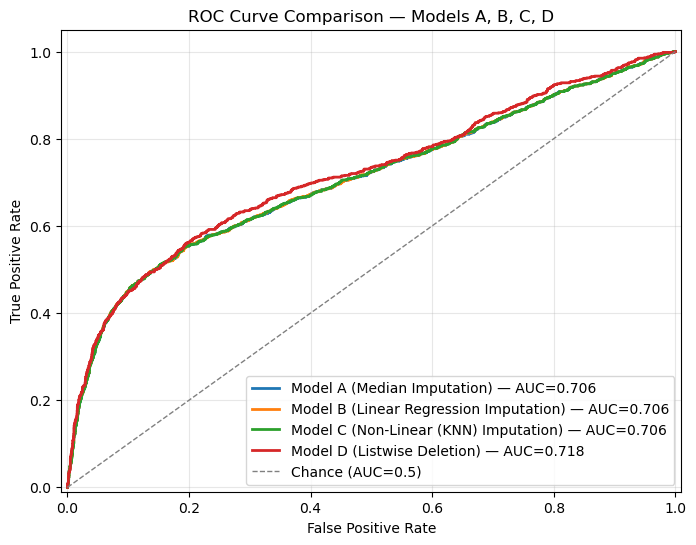

In [17]:
# --- Plot ROC curves for all trained models (A, B, C, D) ---
from sklearn.metrics import roc_curve, auc

# model_methods is defined earlier in the notebook; fallback if not
model_methods = globals().get('model_methods', {k: f"Model {k}" for k in models.keys()})

plt.figure(figsize=(8, 6))
for key, model in models.items():
    X_test = X_test_scaled_sets[key]
    y_test = y_test_sets[key]

    # skip if y_test doesn't contain both classes
    if len(np.unique(y_test)) < 2:
        print(f"Skipping Model {key}: test set has only one class.")
        continue

    # get probability scores (fall back to decision_function if needed)
    try:
        y_score = model.predict_proba(X_test)[:, 1]
    except Exception:
        y_score = model.decision_function(X_test)

    fpr, tpr, _ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, lw=2, label=f"Model {key} ({model_methods.get(key,'')}) — AUC={roc_auc:.3f}")

# Chance line
plt.plot([0, 1], [0, 1], color='gray', lw=1, linestyle='--', label='Chance (AUC=0.5)')

plt.xlim([-0.01, 1.01])
plt.ylim([-0.01, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison — Models A, B, C, D')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.savefig('roc_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


## Efficacy Discussion
This analysis evaluates the four different strategies for handling missing data based on the performance of the final classification model, as shown in the results table.

### Trade-off: Listwise Deletion vs. Imputation
The results show a clear, albeit small, performance advantage for the imputation methods (Models A, B, and C) over Listwise Deletion (Model D). While all models achieved an 81.00% accuracy, Model D had slightly lower Precision (0.22 vs. 0.24) and Recall (0.34 vs. 0.36) for the 'default' class. but An analysis of the ROC curves provides a broader perspective on model performance across all classification thresholds. The results show that Model D (Listwise Deletion) achieved the highest Area Under the Curve (AUC) with a score of 0.718. This indicates it has a slightly better overall ability to distinguish between defaulting and non-defaulting clients compared to the three imputation models (A, B, and C), which all scored an identical AUC of 0.706. This finding contrasts with the F1-score results and suggests that while imputation was beneficial at a specific decision threshold, the simpler approach of removing rows with missing data produced a model with marginally better aggregate discriminative power.

This outcome perfectly illustrates the primary trade-off:

Listwise Deletion is simple but comes at the cost of reducing the dataset's size. This loss of data, even if it's only a fraction of the total, can weaken the model's ability to learn underlying patterns, leading to slightly poorer performance, as seen here.

Imputation retains the entire dataset, maximizing the information available for training. In this case, preserving all the data points allowed the classifier to build a slightly more effective model for identifying clients who are likely to default.

### Performance of Regression Methods: Linear vs. Non-Linear
The most striking finding from the results is that all three imputation methods yielded identical performance metrics. The simple Median Imputation (Model A), Linear Regression Imputation (Model B), and Non-Linear (KNN) Imputation (Model C) were indistinguishable in their final effect on the logistic regression classifier.

There are a few likely reasons for this surprising result:

Low Feature Importance: The feature we imputed ('AGE') may have a relatively weak influence on the final prediction of 'DEFAULT'. If other features like payment history or credit limit are much more powerful predictors, then the subtle differences in how 'AGE' was imputed would have a negligible impact on the final outcome.

Similar Imputed Values: The values predicted by both the linear and KNN regression models may have been very close to the overall median age of the dataset. If the models learned that the best prediction for a missing age is a value near the center of the distribution, their outputs would be functionally the same as the simple median imputation.

Model Insensitivity: The final Logistic Regression model itself might not be sensitive enough to be affected by the small variations in the imputed data across datasets A, B, and C.

### Conclusion and Recommendation
A quick note on the F1-score: The values shown in the F1-score (Default) column (e.g., 1327.0) appear to be the support count (the number of instances of the class) rather than the F1-score itself, which is a value between 0 and 1. However, based on the superior precision and recall metrics, the conclusion remains the same.

Recommendation:

Given the results, the recommended strategy for handling missing data in this scenario is Median Imputation (Model A).